# Imports and Stuff

In [2]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import random
import numpy as np
import pandas as pd

import pickle
from tqdm import tqdm

In [4]:
# Let's SEEED ! yay
seed =2024

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

## Hyper Params

In [52]:
mainPath = "./data"

num_epochs = 100
honesty_weight = 1.0  # Adjust as necessary
sequencing_error = 0.001
beacon_LR = 0.0001 # beacon need to be a bit conservative because it is not that much complicated model.
attacker_LR = 0.001
batch_size = 1

max_query_length = 5

beacon_input_size = 3 # indices (converts to maf value and category) + prev honesty rate
beacon_hidden_size = 32
beacon_output_size = 1  # Single otput (between 0 and 1)

attacker_input_size = 3 # ndices (converts to maf value and category) + prev honesty rate TODO: check if it is better to sample, or use the honesty
attacker_hidden_size = 128
attacker_output_size = None # will set after data pre-process

default_device = torch.device("cuda")

# 1 Data Loading & Pre-process
## 1.1 loading

In [6]:
# CEU Beacon - it contains 164 people in total which we will divide into groups to experiment
beacon = pd.read_csv(os.path.join(mainPath, "Beacon_164.txt"), index_col=0, delim_whitespace=True)

# Reference genome, i.e. the genome that has no SNPs, all major allele pairs for each position
reference = pickle.load(open(os.path.join(mainPath, "reference.pickle"),"rb"))

# Binary representation of the beacon; 0: no SNP (i.e. no mutation) 1: SNP (i.e. mutation)
binary = np.logical_and(beacon.values != reference, beacon.values != "NN").astype(int) 

# Table that contains MAF (minor allele frequency) values for each position. 
maf = pd.read_csv(os.path.join(mainPath, "MAF.txt"), index_col=0, delim_whitespace=True)
maf.rename(columns = {'referenceAllele':'major', 'referenceAlleleFrequency':'major_freq', 
                      'otherAllele':'minor', 'otherAlleleFrequency':'minor_freq'}, inplace = True)
maf["maf"] = np.round(maf["maf"].values, 3)


# Same variable with sorted maf values
sorted_maf = maf.sort_values(by='maf')

# Extracting column to an array for future use
maf_values = maf["maf"].values

# Prepare index arrays for future use
# beacon_people = np.arange(65)
# other_people = np.arange(99)+65
all_people = np.arange(164)

1.2 Pre-Processing

In [7]:
# MAF values are calculated from a small subset they might be 0. 
# This does not mean they are not seen in anybody in the world so we are replacing 0 MAF values with 0.001 which is a pretty rare value
maf["maf"] = maf["maf"].apply(lambda x: 0.001 if x == 0 else x)
maf_values = maf["maf"].values

**Set the attacker's output**

In [61]:
attacker_output_size = len (maf_values)

**Build beacons, control groups and select victim**</br>
Construct beacons and the victim. Here randomly select

In [9]:
shuffled = np.random.permutation(all_people)

victim_ind_train = shuffled[0:20] # 20 victims
victim_ind_test = shuffled[20:30] # 10 victims

attacker_control_ind = shuffled[30:60] # 30 people at the train control

beacon_ind = shuffled[60:140] # 10 + 5 + 80 people at the beacons 

beacon = binary[:, np.concatenate([beacon_ind, np.array(victim_ind_train[:10]), np.array(victim_ind_test[:5])])] # Victim inside beacon

attacker_control_gp = binary[:,  np.concatenate([attacker_control_ind, victim_ind_train, victim_ind_test])]

victim_train = binary[:, victim_ind_train]
victim_test = binary[:, victim_ind_test]

In [10]:
beacon.shape

(4029840, 95)

**Categorize SNPs**

Categorization is being done using the graph below </br>
</br>
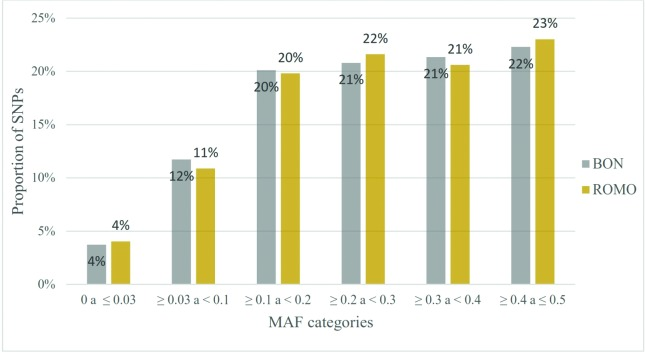 </br>
From paper [Linkage disequilibrium levels and allele frequency distribution in Blanco Orejinegro and Romosinuano Creole cattle using medium density SNP chip data]("https://doi.org/10.1590%2F1678-4685-GMB-2016-0310")

In [11]:
maf_categories = np.zeros_like(maf_values, dtype=np.ubyte)

for i, maf in enumerate(maf_values):
    if maf < .03:
        maf_categories[i] = 0
    elif maf < 0.1:
        maf_categories[i] = 1
    elif maf < 0.2:
        maf_categories[i] = 2
    elif maf < 0.3:
        maf_categories[i] = 3
    elif maf < 0.4:
        maf_categories[i] = 4
    else:
        maf_categories[i] = 5
        

In [12]:
unique, counts = np.unique(maf_categories, return_counts=True)
print(np.asarray((unique, counts)).T)

[[      0 1523880]
 [      1  489892]
 [      2  586786]
 [      3  507101]
 [      4  469570]
 [      5  452611]]


## 1.3 Dataset & Data Loader

In [13]:
class BeaconDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        super(BeaconDataset, self).__init__()
        self.data = data
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

In [48]:
class VictimDataset(BeaconDataset):
    def __init__(self, data, label):
        super().__init__(data)
        self.label = label
        
        if len(self.label) != len(self.data):
            raise ValueError("Data and label arrays should have same length")
        
    def __getitem__(self, idx):
        return self.data[idx], self.label[idx]

In [49]:
# TODO: check and fix the hyper params
# Prepare data
beacon_dataset = BeaconDataset(beacon.T)
attacker_cp_dataset = BeaconDataset(attacker_control_gp.T) 
test_victim_dataset = VictimDataset(victim_test.T, np.concatenate([np.ones(5), np.zeros(5)]))
train_victim_dataset = VictimDataset(victim_train.T, np.concatenate([np.ones(10), np.zeros(10)]))

# Data Loaders
# beacon_dataloader = torch.utils.data.DataLoader(beacon_dataset, batch_size=10, shuffle=True)
train_victim_dataloader = torch.utils.data.DataLoader(train_victim_dataset, batch_size=batch_size, shuffle=True)
test_victim_dataloader = torch.utils.data.DataLoader(test_victim_dataset, batch_size=batch_size, shuffle=True)

In [47]:
print(f'Beacon size: {len(beacon_dataset)}')
print(f'Attacker control group size: {len(attacker_cp_dataset)}')
print(f'Train victim size: {len(test_victim_dataset)}')
print(f'Test victim size: {len(train_victim_dataset)}')

Beacon size: 95
Attacker control group size: 60
Train victim size: 10
Test victim size: 20


# 2 LRT Fuction

In [16]:
def calculate_A(maf, num_people):
    if (len(maf) == 0): 
        return torch.tensor([])
    
    DN_i = torch.pow((1-maf), (2*num_people))
    DN_i_1 = torch.pow((1-maf), (2*num_people-2))
    
    
    return torch.log(1 - DN_i) - torch.log(1 - sequencing_error * DN_i_1)


def calculate_B(maf, num_people):
    if (len(maf) == 0): 
        return torch.tensor([])
    
    DN_i = torch.pow((1-maf), (2*num_people))
    DN_i_1 = torch.pow((1-maf), (2*num_people-2))
    
    return torch.log(DN_i) - torch.log(sequencing_error*DN_i_1)
    

In [17]:
def calculate_lrt(num_people, y, maf, person_responses, beacon_responses):
    # index of queries which has response zero
    Q_0 = torch.where(~beacon_responses)
    # index of queroes which has  response one
    Q_1 = torch.where(beacon_responses)


    # Impact of beacon's zero answers
    zero_flip = torch.sum(person_responses[Q_0] * calculate_B(maf[Q_0], num_people))
    
    y = y[Q_1]
    # Impact of beacon's one answers
    one_flip =  torch.sum(
        person_responses[Q_1] * (
            y * calculate_A(maf[Q_1], num_people) +
            (1 - y) * calculate_B(maf[Q_1], num_people)
        )
    )


    LRT = zero_flip + one_flip
    return  LRT

In [18]:
# Just to test the LRT function
calculate_lrt(60,
              torch.from_numpy(np.array([1])), 
              torch.from_numpy(np.array([0.015])),
              torch.from_numpy(np.array([1])), 
              torch.from_numpy(np.array([True]))
            )

tensor(-0.1778, dtype=torch.float64)

# 2 Models
## 2.1 Beacon model
### 2.1.1 Raw model

In [19]:
class BeaconLSTM(nn.Module):
    device: torch.device
    
    def __init__(self, input_size, hidden_size, output_size, device=default_device):
        super(BeaconLSTM, self).__init__()
          
        self.device = device
        print(f'Initializing BeaconLSTM')
        print(f'Using device: {self.device}')
        
        # define the properties
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        # lstm cell
        self.lstm_cell = nn.LSTMCell(input_size=input_size, hidden_size=hidden_size).to(self.device)
    
        # output fully connected layer
        self.fc_out = nn.Linear(in_features=self.hidden_size, out_features=self.output_size)
        
        self.activation = nn.Sigmoid()
        
        self.register_buffer('maf_categories', torch.from_numpy(maf_categories).to(device))
        self.register_buffer('maf_values', torch.from_numpy(maf_values).to(device))
        
        
    def __get_previous_queries_features(self, previous_queries) -> torch.Tensor:
        SNP_indices = previous_queries[:,:,0].to(self.device).to(torch.int64)
        beacon_answers = previous_queries[:,:,1].to(self.device)
        
        expanded_maf_categories = self.maf_categories.unsqueeze(0).expand(SNP_indices.size(0), -1)
        expanded_maf_values = self.maf_values.unsqueeze(0).expand(SNP_indices.size(0), -1)
        
        SNP_categories = torch.gather(expanded_maf_categories, 1, SNP_indices)
        SNP_maf_values = torch.gather(expanded_maf_values, 1, SNP_indices)
        
        return torch.stack((beacon_answers, SNP_categories, SNP_maf_values), dim=2).float()
    
    
    def forward(self, previous_queries):
        """Gives the next honesty of rate of the answer to the current query. (between 0 and 1)
        
        Keyword arguments:
        previous_queries - stacked (SNP index, beacon response)
        """
        
        # batch size
        batch_size = previous_queries.size(0)
        
        # query length is equal to all of the previous queries.
        query_length = previous_queries.shape[1]
        
        # init the hidden and cell states to zeros
        hidden_state = torch.zeros((batch_size, self.hidden_size)).to(self.device)
        cell_state = torch.zeros((batch_size, self.hidden_size)).to(self.device)
        
        previous_query_features = self.__get_previous_queries_features(previous_queries) # previous queries features
        
        # pass the incoming query alongside with the previous ones
        for t in range(query_length):
            hidden_state, cell_state = self.lstm_cell(previous_query_features[:, t, :], (hidden_state, cell_state))
            
        # output of the attention mechanism
        out = self.activation(
            self.fc_out(hidden_state)
        )
    
        return out

### 2.1.2 Initialize the Weights and Biases
To bias the output towards "1", we want 100% honesty from the beacon the the first step.

In [20]:
def initialize_beacon_lstm_honest(beacon_lstm):
    # Initialize the input-hidden weights
    for name, param in beacon_lstm.named_parameters():
        if 'weight_ih' in name:
            nn.init.xavier_uniform_(param)
        elif 'weight_hh' in name:
            nn.init.xavier_uniform_(param)
        elif 'bias_ih' in name:
            nn.init.zeros_(param)
        elif 'bias_hh' in name:
            nn.init.zeros_(param)

    # Initialize the fully connected layer
    nn.init.xavier_uniform_(beacon_lstm.fc_out.weight)
    nn.init.constant_(beacon_lstm.fc_out.bias, 10.0)  

In [21]:

beacon_lstm = BeaconLSTM(beacon_input_size, beacon_hidden_size, beacon_output_size).to(default_device)

initialize_beacon_lstm_honest(beacon_lstm)

Initializing BeaconLSTM
Using device: cuda


Test the model bias

In [22]:
# Example data (replace with your actual test queries and honest responses)
test_queries = torch.randint(0, len(maf_values), (10, 5))  # 10 queries, each with 5 timesteps, each timestep with input_size features
honest_responses = torch.ones(10, 5)  # Assuming the honest response is 1 for all queries
query = torch.stack([test_queries, honest_responses], dim=2)

beacon_lstm.eval()  # Set the model to evaluation mode
with torch.no_grad():
    outputs = beacon_lstm(query.to(default_device))
    
assert outputs.shape[0] == query.shape[0]
assert outputs.shape[1] == 1

margin = outputs.shape[0] - torch.sum(outputs)
assert margin < 0.01

## 2.2 Attacker Model
### 2.2.1 User Encoder

In [23]:
class UserEncoder(nn.Module):
    def __init__(self, conv_output_size, fc1_output_size, fc3_output_size, device=default_device):
        super(UserEncoder, self).__init__()
        
        self.device = device
        print(f'Initializing UserEncoder')
        print(f'Using device: {self.device}')
        
        self.conv1x1 = nn.Conv1d(3, 1, kernel_size=6, stride=3)
        self.fc1 = nn.Linear(conv_output_size, fc1_output_size)
        # self.fc2 = nn.Linear(fc1_output_size, fc2_output_size)
        self.fc3 = nn.Linear(fc1_output_size, fc3_output_size)
        
        self.register_buffer('maf_categories', torch.from_numpy(maf_categories).to(device))
        self.register_buffer('maf_values', torch.from_numpy(maf_values).to(device))
        
        
    def __get_previous_queries_features(self, previous_queries) -> torch.Tensor:
        SNP_indices = previous_queries.to(self.device).to(torch.int64)
        
        expanded_maf_categories = self.maf_categories.unsqueeze(0).expand(SNP_indices.size(0), -1)
        expanded_maf_values = self.maf_values.unsqueeze(0).expand(SNP_indices.size(0), -1)
        
        return torch.stack((SNP_indices, expanded_maf_categories, expanded_maf_values), dim=1).float()
    
    def forward(self, x):
        x = self.__get_previous_queries_features(x.to(self.device))
        x = self.conv1x1(x)
        x = F.relu(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### 2.2.2 Raw Model

In [76]:
class AttackerMLSTM(nn.Module):
    device: torch.device
    
    def __init__(self, input_size, hidden_size, output_size, device=default_device):
        """Initiates the modle.
        
        Keyword arguments:
        input_size - input size
        hidden_size - hidden size
        output_size - output size of SNP array size
        """
        super(AttackerMLSTM, self).__init__()
        
        self.device = device
        print(f'Initializing AttackerMLSTM')
        print(f'Using device: {self.device}')
        
        # define the properties
        self.embed_size = input_size
        self.hidden_size = hidden_size
        self.snp_array_size = output_size
        
        # lstm cell
        self.lstm_cell = nn.LSTMCell(input_size=input_size, hidden_size=hidden_size)
    
        # output fully connected layer
        self.fc_out = nn.Linear(in_features=self.hidden_size, out_features=self.snp_array_size)
        
        self.register_buffer('maf_categories', torch.from_numpy(maf_categories).to(device))
        self.register_buffer('maf_values', torch.from_numpy(maf_values).to(device))
        
        
    def __get_previous_queries_features(self, previous_queries) -> torch.Tensor:
        SNP_indices = previous_queries[:,:,0].to(self.device).to(torch.int64)
        beacon_answers = previous_queries[:,:,1].to(self.device)
        
        expanded_maf_categories = self.maf_categories.unsqueeze(0).expand(SNP_indices.size(0), -1)
        expanded_maf_values = self.maf_values.unsqueeze(0).expand(SNP_indices.size(0), -1)
        
        SNP_categories = torch.gather(expanded_maf_categories, 1, SNP_indices)
        SNP_maf_values = torch.gather(expanded_maf_values, 1, SNP_indices)
                
        return torch.stack((beacon_answers, SNP_categories, SNP_maf_values), dim=2).float()
    
    
    def forward(self, embedded_users, previous_queries: torch.Tensor):
        """Gives the next snp to be queried.
        
        Keyword arguments:
        users - stacked embedded users
        previous_queries - stacked (SNP index, beacon response)
        """
        
        # batch size
        batch_size = embedded_users.size(0)
        
        # query length is equal to all of the previous queries plus one (Embeding).
        query_length = previous_queries.shape[1] + 1
        
        # indices of the previously queried SNPs
        previous_queries_indices = []
        if query_length > 1:
            previous_queries_indices = previous_queries[:, 0].to(torch.int64)
            
            # get features
            previous_query_features = self.__get_previous_queries_features(previous_queries) # previous queries features
        
        
        # init the hidden and cell states to zeros
        hidden_state = torch.zeros((batch_size, self.hidden_size)).to(self.device)
        cell_state = torch.zeros((batch_size, self.hidden_size)).to(self.device)
        
        # iterate over previous queries
        for t in range(query_length):

            # for the first time step the input is the feature vector
            if t == 0:
                hidden_state, cell_state = self.lstm_cell(embedded_users, (hidden_state, cell_state))
                
            # for the 2nd+ time step
            else:
                hidden_state, cell_state = self.lstm_cell(previous_query_features[:, t - 1, :], (hidden_state, cell_state))


        # output of the attention mechanism
        out = self.fc_out(hidden_state)
                
        if query_length > 1:
            # To avoid duplication, we set the values of previously queried SNPs to 0.
            rows = torch.arange(out.size(0)).unsqueeze(1).expand_as(previous_queries_indices) # create row indices
            out[rows, previous_queries_indices] = 0

        outputs = torch.argmax(out, dim=1)
        
        return outputs

### 2.2.3 initialization

In [72]:
conv_output_size = 1343279
fc1_output_size = 400
fc2_output_size = 3

user_encoder = UserEncoder(conv_output_size, fc1_output_size, fc2_output_size)
loaded_state = torch.load('user_encoder.pth')
current_state = user_encoder.state_dict()

for key in loaded_state:
    current_state[key] = loaded_state[key]

user_encoder.load_state_dict(current_state)
user_encoder.to(default_device)
user_encoder.eval()

Initializing UserEncoder
Using device: cuda


UserEncoder(
  (conv1x1): Conv1d(3, 1, kernel_size=(6,), stride=(3,))
  (fc1): Linear(in_features=1343279, out_features=400, bias=True)
  (fc3): Linear(in_features=400, out_features=3, bias=True)
)

In [77]:
if attacker_output_size is None:
    raise ValueError('You forget to set the output')

attacker_mlstm = AttackerMLSTM(
    attacker_input_size,
    attacker_hidden_size,
    attacker_output_size
).to(default_device)

Initializing AttackerMLSTM
Using device: cuda


Test the model

In [27]:
torch.tensor(beacon_dataset[:2]).float().shape

torch.Size([2, 4029840])

In [78]:
# Example data (replace with your actual test queries and honest responses)
test_queries = torch.randint(0, len(maf_values), (10, 5))  # 10 queries, each with 5 timesteps, each timestep with input_size features
honest_responses = torch.ones(10, 5)  # Assuming the honest response is 1 for all queries
query = torch.stack([test_queries, honest_responses], dim=2).to(default_device)

victims = torch.tensor(beacon_dataset[:10]).float()
user_features = user_encoder(victims)

assert user_features.shape[0] == query.shape[0]
assert user_features.shape[1] == 3

attacker_mlstm.eval()  # Set the model to evaluation mode
with torch.no_grad():
    outputs = attacker_mlstm(user_features, query)
    
assert outputs.shape[0] == query.shape[0]
print(outputs.shape)
print(outputs)


torch.Size([10])
tensor([1967833, 3763766, 3729487, 3763766, 3878808, 3763766, 3604235, 3729487,
        3878808, 3763766], device='cuda:0')


## 2.3 Loss functions

### 2.3.1 final loss functions

In [29]:
def beacon_loss_function(lrt_std, lrt_existing_bottom, honesty_rate):
    return lrt_std + lrt_existing_bottom - honesty_rate

def attacker_loss_function(lrt_std, lrt_existing_bottom, lrt_distance):
    return lrt_std - lrt_existing_bottom + lrt_distance

### 2.3.2 Beacon and attacker's LRT calculations

In [30]:
def calculate_group_lrt(queries, honesty, control_group, device=default_device):
    num_people = len(control_group)
    response = torch.from_numpy(control_group[:,queries].any(axis=0)) # get the control group response
    
    resulted_LRTs = torch.zeros((num_people)).to(device)
    snp_maf_values = torch.from_numpy(maf_values[queries])
    
    for i, person in enumerate(control_group):
        resulted_LRTs[i] = calculate_lrt(num_people, honesty, snp_maf_values, torch.from_numpy(person[queries]), response)
        
    return resulted_LRTs

Test

In [31]:
# testing what we have here
test_queries = torch.randint(0, len(maf_values), (10,))
honesty = torch.ones(10)

calculate_group_lrt(
    test_queries,
    honesty,
    beacon_dataset
)

tensor([ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00, -1.5773e-10,  0.0000e+00, -4.8708e-01,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
        -2.5212e-03, -1.5773e-10,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00, -1.5773e-10, -2.5212e-03, -1.5773e-10,
         0.0000e+00,  0.0000e+00,  0.0000e+00, -2.5212e-03,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00, -2.5212e-03,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00, -2.5212e-03,  0.0000e+00, -1.5773e-10,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
        -1.5773e-10,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0

### 2.3.3 Other terms related to the loss function

In [32]:
def calculate_lrt_std(lrts):
    # Coefficience of the std
    mean = torch.mean(lrts)
    std_dev = torch.std(lrts, correction =1)  # correction=1 for sample standard deviation

    return mean / std_dev

def calculate_bottom_20_percent_lrt(lrts):
    return torch.quantile(lrts, 0.2)

def calculate_lrt_distance(lrt_existing, lrt_non_existing):
    return torch.abs(lrt_existing.mean() - lrt_non_existing.mean())

# 3 Training
## 3.1 Optimizers

In [33]:
# Optimizers
attacker_optimizer = optim.Adam(attacker_mlstm.parameters(), lr=attacker_LR)
beacon_optimizer = optim.Adam(beacon_lstm.parameters(), lr=beacon_LR)

## 3.2 Main training loop

In [80]:
# this code is just a placeholder

for epoch in range(num_epochs):
    loop = tqdm(train_victim_dataloader)
    for ind, (data, label) in enumerate(loop):
        data = data.to(default_device).float()
        
        user_features = user_encoder(data) # Get user's features from the encoder
        
        perv_answers = torch.empty((3, 0)).to(default_device).float()
        for query_length in range(max_query_length):      
            # Feed the victim to the attacker's RNN
            new_query = attacker_mlstm(user_features, perv_answers)
            print(new_query)
            raise ValueError()
        
        # Feed the queries to the beacon
        beacon_response = beacon_rnn(query_order)
        
        # Calculate LRTs
        beacon_lrt = calculate_beacon_lrt(beacon_rnn, query_order)
        attacker_lrt_existing = calculate_attacker_lrt(attacker_rnn, query_order, train_data)
        attacker_lrt_non_existing = calculate_attacker_lrt(attacker_rnn, query_order, control_group)
        
        # Compute attacker loss
        lrt_std = calculate_lrt_std(beacon_lrt)
        lrt_existing_bottom = calculate_bottom_20_percent_lrt(beacon_lrt)
        lrt_distance = calculate_lrt_distance(attacker_lrt_existing, attacker_lrt_non_existing)
        
        attacker_loss = attacker_loss_function(lrt_std, lrt_existing_bottom, lrt_distance)
        
        # Backpropagate attacker loss
        attacker_optimizer.zero_grad()
        attacker_loss.backward()
        attacker_optimizer.step()
        
        # Compute beacon loss
        honesty_rate = (beacon_response > 0.5).float().mean()  # Example honesty rate calculation
        
        beacon_loss = beacon_loss_function(lrt_std, lrt_existing_bottom, honesty_weight * honesty_rate)
        
        # Backpropagate beacon loss
        beacon_optimizer.zero_grad()
        beacon_loss.backward()
        beacon_optimizer.step()
        
        
        loop.set_description(f"Epoch [{epoch}/{num_epochs}]")
        loop.set_postfix(beacon_loss=torch.rand(1).item(), attacker_loss=torch.rand(1).item())
    
    # Check for stopping condition based on LRT stability
    if epoch > 5:  # Example condition, implement your logic here
        previous_lrt = current_lrt  # Track previous LRT values
        current_lrt = beacon_lrt  # Update current LRT values
        
        if torch.abs(current_lrt - previous_lrt).mean() < 0.001:  # Example threshold
            print("Stopping training due to LRT stability.")
            break
        


  0%|          | 0/20 [00:00<?, ?it/s]

tensor([1549194], device='cuda:0')


ValueError: 